# Solving classification problems with CatBoost

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/catboost/tutorials/blob/master/classification/classification_tutorial.ipynb)

In this tutorial we will use dataset Amazon Employee Access Challenge from [Kaggle](https://www.kaggle.com) competition for our experiments. Data can be downloaded [here](https://www.kaggle.com/c/amazon-employee-access-challenge/data).

## Libraries installation

In [1]:
# %pip install --user --upgrade catboost
# %pip install --user --upgrade ipywidgets
# %pip install shap
# %pip install sklearn
# %pip install --upgrade numpy
# !jupyter nbextension enable --py widgetsnbextension

In [2]:
import catboost
print(catboost.__version__)
!python --version

0.25.1
Python 3.9.1


## Reading the data

In [3]:
import pandas as pd
import os
import numpy as np
np.set_printoptions(precision=4)
import catboost
from catboost import *
from catboost import datasets

In [4]:
(train_df, test_df) = catboost.datasets.amazon()

In [5]:
train_df.head()

,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1,39353,85475,117961,118300,123472,117905,117906,290919,117908
1,1,17183,1540,117961,118343,123125,118536,118536,308574,118539
2,1,36724,14457,118219,118220,117884,117879,267952,19721,117880
3,1,36135,5396,117961,118343,119993,118321,240983,290919,118322
4,1,42680,5905,117929,117930,119569,119323,123932,19793,119325


## Preparing your data

Label values extraction

In [6]:
y = train_df.ACTION
X = train_df.drop('ACTION', axis=1)

Categorical features declaration

In [7]:
cat_features = list(range(0, X.shape[1]))
print(cat_features)

[0, 1, 2, 3, 4, 5, 6, 7, 8]


Looking on label balance in dataset

In [8]:
print('Labels: {}'.format(set(y)))
print('Zero count = {}, One count = {}'.format(len(y) - sum(y), sum(y)))

Labels: {0, 1}
Zero count = 1897, One count = 30872


Ways to create Pool class

In [9]:
dataset_dir = './amazon'
if not os.path.exists(dataset_dir):
    os.makedirs(dataset_dir)

# We will be able to work with files with/without header and
# with different separators.
train_df.to_csv(
    os.path.join(dataset_dir, 'train.tsv'),
    index=False, sep='\t', header=False
)
test_df.to_csv(
    os.path.join(dataset_dir, 'test.tsv'),
    index=False, sep='\t', header=False
)

train_df.to_csv(
    os.path.join(dataset_dir, 'train.csv'),
    index=False, sep=',', header=True
)
test_df.to_csv(
    os.path.join(dataset_dir, 'test.csv'),
    index=False, sep=',', header=True
)

In [10]:
!head amazon/train.csv

ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
1,39353,85475,117961,118300,123472,117905,117906,290919,117908
1,17183,1540,117961,118343,123125,118536,118536,308574,118539
1,36724,14457,118219,118220,117884,117879,267952,19721,117880
1,36135,5396,117961,118343,119993,118321,240983,290919,118322
1,42680,5905,117929,117930,119569,119323,123932,19793,119325
0,45333,14561,117951,117952,118008,118568,118568,19721,118570
1,25993,17227,117961,118343,123476,118980,301534,118295,118982
1,19666,4209,117961,117969,118910,126820,269034,118638,126822
1,31246,783,117961,118413,120584,128230,302830,4673,128231


In [11]:
from catboost.utils import create_cd
feature_names = dict()
for column, name in enumerate(train_df):
    if column == 0:
        continue
    feature_names[column - 1] = name
    
create_cd(
    label=0, 
    cat_features=list(range(1, train_df.columns.shape[0])),
    feature_names=feature_names,
    output_path=os.path.join(dataset_dir, 'train.cd')
)

In [12]:
!cat amazon/train.cd

0	Label	
1	Categ	RESOURCE
2	Categ	MGR_ID
3	Categ	ROLE_ROLLUP_1
4	Categ	ROLE_ROLLUP_2
5	Categ	ROLE_DEPTNAME
6	Categ	ROLE_TITLE
7	Categ	ROLE_FAMILY_DESC
8	Categ	ROLE_FAMILY
9	Categ	ROLE_CODE


In [13]:
pool1 = Pool(data=X, label=y, cat_features=cat_features)
pool2 = Pool(
    data=os.path.join(dataset_dir, 'train.csv'), 
    delimiter=',', 
    column_description=os.path.join(dataset_dir, 'train.cd'),
    has_header=True
)
pool3 = Pool(data=X, cat_features=cat_features)

# Fastest way to create a Pool is to create it from numpy matrix.
# This way should be used if you want fast predictions
# or fastest way to load the data in python.

X_prepared = X.values.astype(str).astype(object)
# For FeaturesData class categorial features must have type str

pool4 = Pool(
    data=FeaturesData(
        cat_feature_data=X_prepared,
        cat_feature_names=list(X)
    ),
    label=y.values
)

print('Dataset shape')
print('dataset 1:' + str(pool1.shape) +
      '\ndataset 2:' + str(pool2.shape) + 
      '\ndataset 3:' + str(pool3.shape) +
      '\ndataset 4: ' + str(pool4.shape))

print('\n')
print('Column names')
print('dataset 1:')
print(pool1.get_feature_names()) 
print('\ndataset 2:')
print(pool2.get_feature_names())
print('\ndataset 3:')
print(pool3.get_feature_names())
print('\ndataset 4:')
print(pool4.get_feature_names())

Dataset shape
dataset 1:(32769, 9)
dataset 2:(32769, 9)
dataset 3:(32769, 9)
dataset 4: (32769, 9)


Column names
dataset 1:
['RESOURCE', 'MGR_ID', 'ROLE_ROLLUP_1', 'ROLE_ROLLUP_2', 'ROLE_DEPTNAME', 'ROLE_TITLE', 'ROLE_FAMILY_DESC', 'ROLE_FAMILY', 'ROLE_CODE']

dataset 2:
['RESOURCE', 'MGR_ID', 'ROLE_ROLLUP_1', 'ROLE_ROLLUP_2', 'ROLE_DEPTNAME', 'ROLE_TITLE', 'ROLE_FAMILY_DESC', 'ROLE_FAMILY', 'ROLE_CODE']

dataset 3:
['RESOURCE', 'MGR_ID', 'ROLE_ROLLUP_1', 'ROLE_ROLLUP_2', 'ROLE_DEPTNAME', 'ROLE_TITLE', 'ROLE_FAMILY_DESC', 'ROLE_FAMILY', 'ROLE_CODE']

dataset 4:
['RESOURCE', 'MGR_ID', 'ROLE_ROLLUP_1', 'ROLE_ROLLUP_2', 'ROLE_DEPTNAME', 'ROLE_TITLE', 'ROLE_FAMILY_DESC', 'ROLE_FAMILY', 'ROLE_CODE']


## Split your data into train and validation

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.8, random_state=1234)

## Selecting the objective function

Possible options for binary classification:

`Logloss`

`CrossEntropy` for probabilities in target

In [15]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=5,
    learning_rate=0.1,
    # loss_function=metrics.CrossEntropy()
)
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    verbose=False
)
print('Model is fitted: ' + str(model.is_fitted()))
print('Model params:')
print(model.get_params())

Model is fitted: True
Model params:
{'iterations': 5, 'learning_rate': 0.1}


## Stdout of the training

In [16]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=15,
#     verbose=5,
)
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
)

Learning rate set to 0.441257
0:	learn: 0.4220777	test: 0.4223741	best: 0.4223741 (0)	total: 7.98ms	remaining: 112ms
1:	learn: 0.3149660	test: 0.3151186	best: 0.3151186 (1)	total: 17.1ms	remaining: 111ms
2:	learn: 0.2621494	test: 0.2629766	best: 0.2629766 (2)	total: 25.2ms	remaining: 101ms
3:	learn: 0.2302316	test: 0.2302315	best: 0.2302315 (3)	total: 35.3ms	remaining: 97.2ms
4:	learn: 0.2060274	test: 0.2019603	best: 0.2019603 (4)	total: 43.6ms	remaining: 87.2ms
5:	learn: 0.1956107	test: 0.1894627	best: 0.1894627 (5)	total: 51.9ms	remaining: 77.9ms
6:	learn: 0.1870345	test: 0.1790904	best: 0.1790904 (6)	total: 60.5ms	remaining: 69.1ms
7:	learn: 0.1836943	test: 0.1748030	best: 0.1748030 (7)	total: 68.3ms	remaining: 59.7ms
8:	learn: 0.1807119	test: 0.1707896	best: 0.1707896 (8)	total: 76.6ms	remaining: 51.1ms
9:	learn: 0.1775777	test: 0.1662489	best: 0.1662489 (9)	total: 86.6ms	remaining: 43.3ms
10:	learn: 0.1762130	test: 0.1654446	best: 0.1654446 (10)	total: 92.7ms	remaining: 33.7ms
11:

## Metrics calculation and graph plotting

In [17]:
from catboost import CatBoostClassifier
from catboost import metrics

model = CatBoostClassifier(
    iterations=50,
    random_seed=63,
    learning_rate=0.5,
    custom_loss=[metrics.AUC(), metrics.Accuracy()]
)
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

## Model comparison

In [18]:
model1 = CatBoostClassifier(
    learning_rate=0.7,
    iterations=100,
    random_seed=0,
    train_dir='learing_rate_0.7'
)

model2 = CatBoostClassifier(
    learning_rate=0.01,
    iterations=100,
    random_seed=0,
    train_dir='learing_rate_0.01'
)
model1.fit(
    X_train, y_train,
    eval_set=(X_validation, y_validation),
    cat_features=cat_features,
    verbose=False
)
model2.fit(
    X_train, y_train,
    eval_set=(X_validation, y_validation),
    cat_features=cat_features,
    verbose=False
)

In [19]:
from catboost import MetricVisualizer
MetricVisualizer(['learing_rate_0.01', 'learing_rate_0.7']).start()

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

## Best iteration

In [20]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=100,
    random_seed=63,
    learning_rate=0.5,
#     use_best_model=False
)
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [21]:
print('Tree count: ' + str(model.tree_count_))

Tree count: 82


## Cross-validation

In [22]:
from catboost import cv

params = {}
params['loss_function'] = metrics.Logloss()
params['iterations'] = 80
params['custom_loss'] = metrics.AUC()
params['random_seed'] = 63
params['learning_rate'] = 0.5

cv_data = cv(
    params = params,
    pool = Pool(X, label=y, cat_features=cat_features),
    fold_count=5,
    shuffle=True,
    partition_random_seed=0,
    plot=True,
    stratified=False,
    verbose=False
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [23]:
cv_data.head()

,iterations,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std,test-AUC-mean,test-AUC-std
0,0,0.302364,0.003822,0.302515,0.003228,0.527207,0.024999
1,1,0.229273,0.010174,0.230326,0.003786,0.626225,0.049300
2,2,0.191364,0.007548,0.197340,0.002161,0.785209,0.022718
3,3,0.179259,0.008272,0.187322,0.001199,0.810380,0.009422
4,4,0.173020,0.007728,0.182187,0.001872,0.825013,0.010570


In [24]:
best_value = np.min(cv_data['test-Logloss-mean'])
best_iter = np.argmin(cv_data['test-Logloss-mean'])

print('Best validation Logloss score, not stratified: {:.4f}±{:.4f} on step {}'.format(
    best_value,
    cv_data['test-Logloss-std'][best_iter],
    best_iter)
)

Best validation Logloss score, not stratified: 0.1577±0.0083 on step 33


In [25]:
cv_data = cv(
    params = params,
    pool = Pool(X, label=y, cat_features=cat_features),
    fold_count=5,
    type = 'Classical',
    shuffle=True,
    partition_random_seed=0,
    plot=True,
    stratified=True,
    verbose=False
)

best_value = np.min(cv_data['test-Logloss-mean'])
best_iter = np.argmin(cv_data['test-Logloss-mean'])

print('Best validation Logloss score, stratified: {:.4f}±{:.4f} on step {}'.format(
    best_value,
    cv_data['test-Logloss-std'][best_iter],
    best_iter)
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Best validation Logloss score, stratified: 0.1578±0.0028 on step 44


## Overfitting detector

In [26]:
model_with_early_stop = CatBoostClassifier(
    iterations=200,
    random_seed=63,
    learning_rate=0.5,
    early_stopping_rounds=20
)
model_with_early_stop.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [27]:
print(model_with_early_stop.tree_count_)

66


In [28]:
model_with_early_stop = CatBoostClassifier(
    eval_metric=metrics.AUC(),
    iterations=200,
    random_seed=63,
    learning_rate=0.5,
    early_stopping_rounds=20
)
model_with_early_stop.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [29]:
print(model_with_early_stop.tree_count_)

66


## Select decision boundary

In [30]:
model = CatBoostClassifier(
    random_seed=63,
    iterations=200,
    learning_rate=0.03,
)
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

![](https://habrastorage.org/webt/y4/1q/yq/y41qyqfm9mcerp2ziys48phpjia.png)

In [31]:
from catboost.utils import get_roc_curve
import sklearn

eval_pool = Pool(X_validation, y_validation, cat_features=cat_features)
curve = get_roc_curve(model, eval_pool)
(fpr, tpr, thresholds) = curve
roc_auc = sklearn.metrics.auc(fpr, tpr)

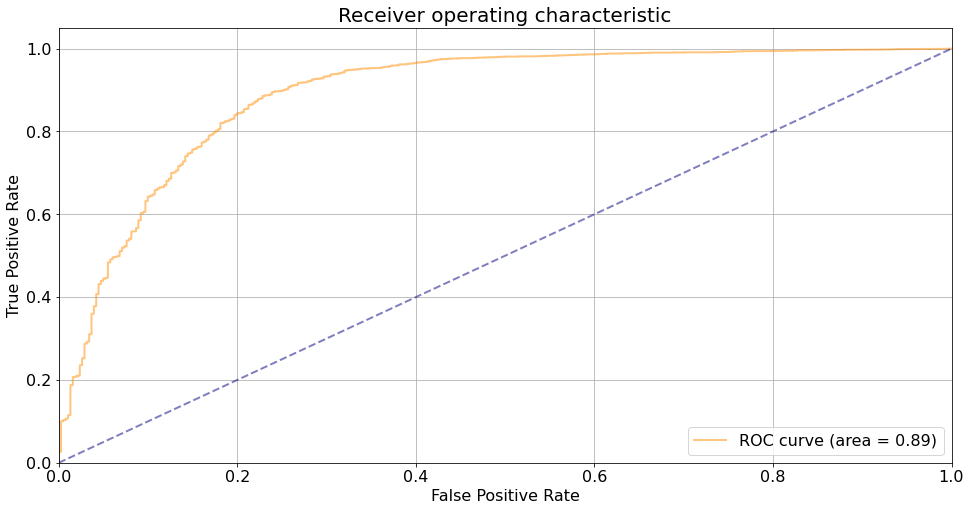

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))
lw = 2

plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc, alpha=0.5)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('Receiver operating characteristic', fontsize=20)
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [33]:
from catboost.utils import get_fpr_curve
from catboost.utils import get_fnr_curve

(thresholds, fpr) = get_fpr_curve(curve=curve)
(thresholds, fnr) = get_fnr_curve(curve=curve)

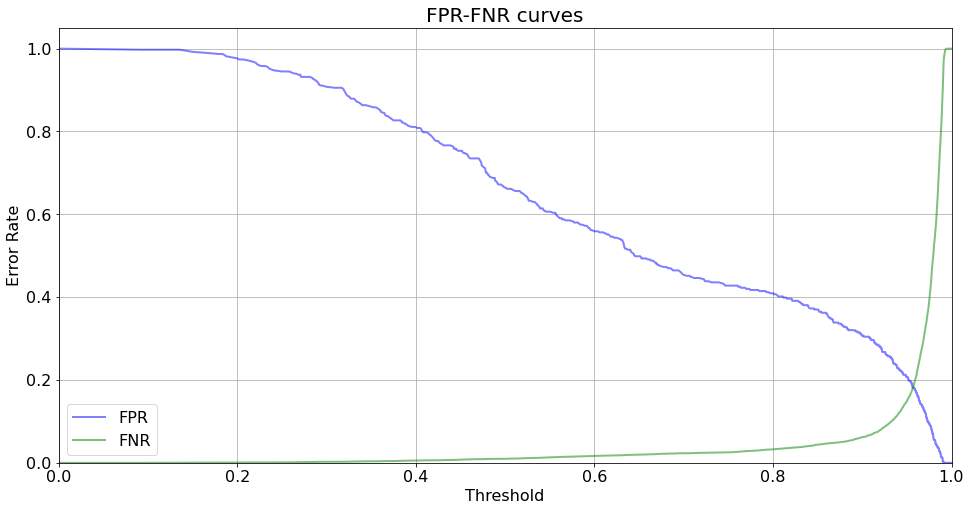

In [34]:
plt.figure(figsize=(16, 8))
lw = 2

plt.plot(thresholds, fpr, color='blue', lw=lw, label='FPR', alpha=0.5)
plt.plot(thresholds, fnr, color='green', lw=lw, label='FNR', alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('Threshold', fontsize=16)
plt.ylabel('Error Rate', fontsize=16)
plt.title('FPR-FNR curves', fontsize=20)
plt.legend(loc="lower left", fontsize=16)
plt.show()

In [35]:
label = eval_pool.get_label()
print(model.get_probability_threshold())
print(metrics.Precision().eval(label, model.predict(eval_pool)))

model.set_probability_threshold(0.2)
print(metrics.Precision().eval(label, model.predict(eval_pool)))


0.5
[0.9602576185988062]
[0.943127962085308]


## Snapshotting

In [36]:
# !rm 'catboost_info/snapshot.bkp'
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=100,
    save_snapshot=True,
    snapshot_file='snapshot.bkp',
    snapshot_interval=1,
    random_seed=43
)
model.fit(
    X_train, y_train,
    eval_set=(X_validation, y_validation),
    cat_features=cat_features,
    verbose=True
)

Learning rate set to 0.193326

bestTest = 0.1575677776
bestIteration = 80

Shrink model to first 81 iterations.


## Model predictions

In [37]:
print(model.predict_proba(data=X_validation))

[[0.0508 0.9492]
 [0.0181 0.9819]
 [0.0179 0.9821]
 ...
 [0.0161 0.9839]
 [0.017  0.983 ]
 [0.0236 0.9764]]


In [38]:
print(model.predict(data=X_validation))

[1 1 1 ... 1 1 1]


In [39]:
raw_pred = model.predict(
    data=X_validation,
    prediction_type='RawFormulaVal'
)
print(raw_pred)

[2.9282 3.9947 4.0077 ... 4.1115 4.06   3.7207]


In [40]:
from numpy import exp

sigmoid = lambda x: 1 / (1 + exp(-x))

probabilities = sigmoid(raw_pred)

print(probabilities)

[0.9492 0.9819 0.9821 ... 0.9839 0.983  0.9764]


In [41]:
X_prepared = X_validation.values.astype(str).astype(object)
# For FeaturesData class categorial features must have type str

fast_predictions = model.predict_proba(
    data=FeaturesData(
        cat_feature_data=X_prepared,
        cat_feature_names=list(X_validation)
    )
)
print(fast_predictions)

[[0.0508 0.9492]
 [0.0181 0.9819]
 [0.0179 0.9821]
 ...
 [0.0161 0.9839]
 [0.017  0.983 ]
 [0.0236 0.9764]]


## Staged prediction

In [42]:
predictions_gen = model.staged_predict_proba(
    data=X_validation,
    ntree_start=0, 
    ntree_end=5, 
    eval_period=1
)
try:
    for iteration, predictions in enumerate(predictions_gen):
        print('Iteration ' + str(iteration) + ', predictions:')
        print(predictions)
except Exception:
    pass

Iteration 0, predictions:
[[0.4154 0.5846]
 [0.4154 0.5846]
 [0.4154 0.5846]
 ...
 [0.4154 0.5846]
 [0.4154 0.5846]
 [0.4154 0.5846]]
Iteration 1, predictions:
[[0.3476 0.6524]
 [0.3476 0.6524]
 [0.3476 0.6524]
 ...
 [0.3476 0.6524]
 [0.3476 0.6524]
 [0.3476 0.6524]]
Iteration 2, predictions:
[[0.292  0.708 ]
 [0.292  0.708 ]
 [0.2978 0.7022]
 ...
 [0.2978 0.7022]
 [0.292  0.708 ]
 [0.2978 0.7022]]
Iteration 3, predictions:
[[0.2485 0.7515]
 [0.2485 0.7515]
 [0.2538 0.7462]
 ...
 [0.2538 0.7462]
 [0.2485 0.7515]
 [0.2538 0.7462]]
Iteration 4, predictions:
[[0.2126 0.7874]
 [0.2126 0.7874]
 [0.2173 0.7827]
 ...
 [0.2173 0.7827]
 [0.2126 0.7874]
 [0.2173 0.7827]]


## Solving MultiClassification problem

In [43]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=50,
    random_seed=43,
    loss_function=metrics.MultiClass()
)
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

For multiclass problems with many classes sometimes it's better to solve classification problem using ranking.
To do that we will build a dataset with groups.
Every group will represent one object from our initial dataset.
But it will have one additional categorical feature - possible class value.
Target values will be equal to 1 if the class value is equal to the correct class, and 0 otherwise.
Thus each group will have exactly one 1 in labels, and some zeros.
You can put all possible class values in the group or you can try setting only hard negatives if there are too many labels.
We'll show this approach on an example of binary classification problem.

In [44]:
from copy import deepcopy
def build_multiclass_ranking_dataset(X, y, cat_features, label_values=[0,1], start_group_id=0):
    ranking_matrix = []
    ranking_labels = []
    group_ids = []

    X_train_matrix = X.values
    y_train_vector = y.values

    for obj_idx in range(X.shape[0]):
        obj = list(X_train_matrix[obj_idx])

        for label in label_values:
            obj_of_given_class = deepcopy(obj)
            obj_of_given_class.append(label)
            ranking_matrix.append(obj_of_given_class)
            ranking_labels.append(float(y_train_vector[obj_idx] == label)) 
            group_ids.append(start_group_id + obj_idx)
        
    final_cat_features = deepcopy(cat_features)
    final_cat_features.append(X.shape[1]) # new feature that we are adding should be categorical.
    return Pool(ranking_matrix, ranking_labels, cat_features=final_cat_features, group_id = group_ids)

In [45]:
from catboost import CatBoost
params = {'iterations':150, 'learning_rate':0.01, 'l2_leaf_reg':30, 'random_seed':0, 'loss_function':metrics.QuerySoftMax()}

groupwise_train_pool = build_multiclass_ranking_dataset(X_train, y_train, cat_features, [0,1])
groupwise_eval_pool = build_multiclass_ranking_dataset(X_validation, y_validation, cat_features, [0,1], X_train.shape[0])

model = CatBoost(params)
model.fit(
    X=groupwise_train_pool,
    verbose=False,
    eval_set=groupwise_eval_pool,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Doing predictions with ranking mode

In [46]:
import math

obj = list(X_validation.values[0])
ratings = []
for label in [0,1]:
    obj_with_label = deepcopy(obj)
    obj_with_label.append(label)
    rating = model.predict([obj_with_label])[0]
    ratings.append(rating)
print('Raw values:', np.array(ratings))

def soft_max(values):
    return [math.exp(val) / sum([math.exp(val) for val in values]) for val in values]

print('Probabilities', np.array(soft_max(ratings)))

Raw values: [-0.471   0.4713]
Probabilities [0.2804 0.7196]


## Metric evaluation on a new dataset

In [47]:
model = CatBoostClassifier(
    random_seed=63,
    iterations=200,
    learning_rate=0.03,
)
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    verbose=50
)

0:	learn: 0.6569860	total: 12ms	remaining: 2.38s
50:	learn: 0.1939726	total: 689ms	remaining: 2.01s
100:	learn: 0.1652943	total: 1.52s	remaining: 1.49s
150:	learn: 0.1579126	total: 2.63s	remaining: 852ms
199:	learn: 0.1538675	total: 3.84s	remaining: 0us


In [48]:
from catboost import metrics
metrics_ = model.eval_metrics(
    data=pool1,
    metrics=[metrics.Logloss(), metrics.AUC()],
    ntree_start=0,
    ntree_end=0,
    eval_period=1,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [49]:
print('AUC values:')
print(np.array(metrics_['AUC']))

AUC values:
[0.4998 0.538  0.5504 0.5888 0.6536 0.6515 0.6476 0.648  0.7117 0.731
 0.7277 0.7278 0.724  0.7193 0.72   0.7161 0.7217 0.7217 0.7308 0.7308
 0.7322 0.7502 0.759  0.7581 0.7864 0.8018 0.808  0.808  0.8132 0.8234
 0.8234 0.8234 0.8257 0.8379 0.8505 0.8626 0.8694 0.8727 0.8842 0.8892
 0.8929 0.8975 0.9004 0.9015 0.9032 0.9081 0.9093 0.9099 0.9137 0.9142
 0.9156 0.9161 0.9176 0.9178 0.9209 0.925  0.9273 0.9299 0.9309 0.9337
 0.9342 0.9345 0.9349 0.9349 0.9351 0.9377 0.9395 0.9411 0.9417 0.9417
 0.943  0.9438 0.9437 0.9444 0.9451 0.9468 0.9482 0.95   0.9511 0.9514
 0.9521 0.9537 0.9544 0.955  0.9553 0.9558 0.9568 0.958  0.9592 0.9604
 0.9612 0.9615 0.9621 0.9624 0.9632 0.9641 0.9645 0.9649 0.9652 0.9655
 0.9659 0.9662 0.9664 0.9665 0.9668 0.967  0.9671 0.9672 0.9676 0.9677
 0.9677 0.9678 0.9681 0.9681 0.9684 0.9684 0.9685 0.9685 0.9686 0.9692
 0.97   0.9705 0.9709 0.9715 0.9719 0.9722 0.9725 0.9729 0.973  0.9733
 0.9735 0.9735 0.9738 0.9741 0.9741 0.9742 0.9744 0.9747 0.9751 0.


## Feature importances

In [50]:
model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,RESOURCE,22.294786
1,ROLE_DEPTNAME,17.358273
2,MGR_ID,16.110675
3,ROLE_ROLLUP_2,11.171312
4,ROLE_FAMILY_DESC,9.765429
5,ROLE_TITLE,9.336713
6,ROLE_FAMILY,5.904189
7,ROLE_CODE,5.104764
8,ROLE_ROLLUP_1,2.953858


## Shap values

In [51]:
shap_values = model.get_feature_importance(pool1, type='ShapValues')
expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]
print(shap_values.shape)

(32769, 9)


In [52]:
import shap

shap.initjs()
shap.force_plot(expected_value, shap_values[3,:], X.iloc[3,:])

In [53]:
import shap

shap.initjs()
shap.force_plot(expected_value, shap_values[91,:], X.iloc[91,:])

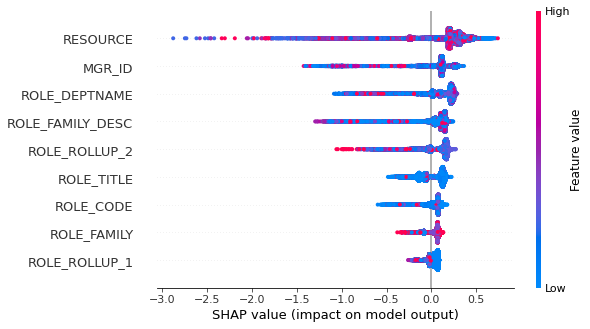

In [54]:
shap.summary_plot(shap_values, X)

In [55]:
X_small = X.iloc[0:200]
shap_small = shap_values[:200]
shap.force_plot(expected_value, shap_small, X_small)

## Feature evaluation

In [56]:
from catboost.eval.catboost_evaluation import *
learn_params = {'iterations': 20, # 2000
                'learning_rate': 0.5, # we set big learning_rate,
                                      # because we have small
                                      # #iterations
                'random_seed': 0,
                'verbose': False,
                'loss_function' : 'Logloss',
                'boosting_type': 'Plain'}
evaluator = CatboostEvaluation('amazon/train.tsv',
                               fold_size=10000, # <= 50% of dataset
                               fold_count=20,
                               column_description='amazon/train.cd',
                               partition_random_seed=0,
                               #working_dir=... 
)
result = evaluator.eval_features(learn_config=learn_params,
                                 eval_metrics=[metrics.Logloss(), metrics.Accuracy()],
                                 features_to_eval=[6, 7, 8])

In [57]:
from catboost.eval.evaluation_result import *
logloss_result = result.get_metric_results('Logloss')
logloss_result.get_baseline_comparison(
    ScoreConfig(ScoreType.Rel, overfit_iterations_info=False)
)

,PValue,Score,Quantile 0.005,Quantile 0.995,Decision
Features: 6,0.000189,1.010962,0.647569,1.444900,GOOD
Features: 7,0.681322,-0.033237,-0.340603,0.304832,UNKNOWN
Features: 8,0.005111,-0.439271,-0.769327,-0.107431,BAD


## Saving the model

In [58]:
my_best_model = CatBoostClassifier(iterations=10)
my_best_model.fit(
    X_train, y_train,
    eval_set=(X_validation, y_validation),
    cat_features=cat_features,
    verbose=False
)
my_best_model.save_model('catboost_model.bin')
my_best_model.save_model('catboost_model.json', format='json')

In [59]:
my_best_model.load_model('catboost_model.bin')
print(my_best_model.get_params())
print(my_best_model.random_seed_)

{'iterations': 10, 'loss_function': 'Logloss', 'verbose': 0}
0


## Hyperparameter tunning

### Training speed

In [60]:
from catboost import CatBoost
fast_model = CatBoostClassifier(
    random_seed=63,
    iterations=150,
    learning_rate=0.01,
    boosting_type='Plain',
    bootstrap_type='Bernoulli',
    subsample=0.5,
    one_hot_max_size=20,
    rsm=0.5,
    leaf_estimation_iterations=5,
    max_ctr_complexity=1)

fast_model.fit(
    X_train, y_train,
    cat_features=cat_features,
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

### Accuracy

In [61]:
tunned_model = CatBoostClassifier(
    random_seed=63,
    iterations=1000,
    learning_rate=0.03,
    l2_leaf_reg=3,
    bagging_temperature=1,
    random_strength=1,
    one_hot_max_size=2,
    leaf_estimation_method='Newton'
)
tunned_model.fit(
    X_train, y_train,
    cat_features=cat_features,
    verbose=False,
    eval_set=(X_validation, y_validation),
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

## Training the model after parameter tunning

In [62]:
best_model = CatBoostClassifier(
    random_seed=63,
    iterations=int(tunned_model.tree_count_ * 1.2),
)
best_model.fit(
    X, y,
    cat_features=cat_features,
    verbose=100
)

Learning rate set to 0.054111
0:	learn: 0.6301383	total: 10.7ms	remaining: 8.89s
100:	learn: 0.1510104	total: 2.22s	remaining: 16.1s
200:	learn: 0.1447436	total: 4.93s	remaining: 15.5s
300:	learn: 0.1401697	total: 7.72s	remaining: 13.6s
400:	learn: 0.1364221	total: 10.5s	remaining: 11.3s
500:	learn: 0.1327339	total: 13.4s	remaining: 8.86s
600:	learn: 0.1291166	total: 16.3s	remaining: 6.25s
700:	learn: 0.1259040	total: 19.1s	remaining: 3.56s
800:	learn: 0.1224291	total: 21.9s	remaining: 849ms
831:	learn: 0.1214100	total: 22.8s	remaining: 0us


## Calculate predictions for the contest

In [63]:
X_test = test_df.drop('id', axis=1)
test_pool = Pool(data=X_test, cat_features=cat_features)
contest_predictions = best_model.predict_proba(test_pool)
print('Predictoins:')
print(contest_predictions)

Predictoins:
[[0.3674 0.6326]
 [0.0097 0.9903]
 [0.0106 0.9894]
 ...
 [0.0051 0.9949]
 [0.0508 0.9492]
 [0.0122 0.9878]]


## Prepare the submission

In [64]:
f = open('submit.csv', 'w')
f.write('Id,Action\n')
for idx in range(len(contest_predictions)):
    line = str(test_df['id'][idx]) + ',' + str(contest_predictions[idx][1]) + '\n'
    f.write(line)
f.close()

Submit your solution [here](https://www.kaggle.com/c/amazon-employee-access-challenge/submit).
Good luck!!!